<a href="https://colab.research.google.com/github/Bast-aleja/Marketing_1/blob/main/Depuracion_bases_Entrega_final_modulo_finanzas_Seguros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTACIÓN DE PAQUETES**

In [ ]:
##importar paquetes
import pandas as pd
import numpy as np
import random 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from io import StringIO
import pydotplus
from sklearn import tree
import pickle
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#importar datos 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**LECTURA BASE DE DATOS**

In [ ]:
# cargar bases
BD_Expuestos= pd.read_csv('/content/drive/MyDrive/ANALITICA3/BD_Expuestos_2.csv', sep=";")
BD_Sociodemografia= pd.read_csv('/content/drive/MyDrive/ANALITICA3/BD_Sociodemografia_2.csv' , encoding='latin-1', sep=";")
BD_Siniestros= pd.read_csv('/content/drive/MyDrive/ANALITICA3/DB_Siniestros_2.csv' , encoding='latin-1', sep=";")

**TRATAMIENTO BD EXPUESTOS**

In [ ]:
#Visualizar BD
BD_Expuestos.head(2)

,Asegurado_Id,Poliza_Asegurado_Id,FECHA_INICIO,FECHA_CANCELACION,FECHA_FIN
0,16286173,125696117,2018/01/01,2018/04/10,2018/04/10
1,11885152,141320760,2018/01/01,NaN,2019/12/31


In [ ]:
#Información general BD
BD_Expuestos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300900 entries, 0 to 300899
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Asegurado_Id         300900 non-null  int64 
 1   Poliza_Asegurado_Id  300900 non-null  int64 
 2   FECHA_INICIO         300900 non-null  object
 3   FECHA_CANCELACION    151963 non-null  object
 4   FECHA_FIN            300900 non-null  object
dtypes: int64(2), object(3)
memory usage: 11.5+ MB


In [ ]:
#Analizar dimensión, tipos y nulos
print(BD_Expuestos.shape)
print('-------------------------------------------------')
print(BD_Expuestos.isnull().sum())
print('-------------------------------------------------')
print(BD_Expuestos.dtypes)
print('-------------------------------------------------')

(300900, 5)
-------------------------------------------------
Asegurado_Id                0
Poliza_Asegurado_Id         0
FECHA_INICIO                0
FECHA_CANCELACION      148937
FECHA_FIN                   0
dtype: int64
-------------------------------------------------
Asegurado_Id            int64
Poliza_Asegurado_Id     int64
FECHA_INICIO           object
FECHA_CANCELACION      object
FECHA_FIN              object
dtype: object
-------------------------------------------------


In [ ]:
#Cambiar algunos nombres 
BD_Expuestos= BD_Expuestos.rename(columns={'Asegurado_Id':'id_cliente', 'Poliza_Asegurado_Id':'cod_poliza'})

In [ ]:
#Cambiar a minusculas el nombre de las columnas
BD_Expuestos.columns = BD_Expuestos.columns.str.lower()
BD_Expuestos.columns

Index(['id_cliente', 'cod_poliza', 'fecha_inicio', 'fecha_cancelacion',
       'fecha_fin'],
      dtype='object')

In [ ]:
#Arreglar el tipo de dato de las columnas
BD_Expuestos=BD_Expuestos.convert_dtypes()
BD_Expuestos.dtypes

id_cliente            Int64
cod_poliza            Int64
fecha_inicio         string
fecha_cancelacion    string
fecha_fin            string
dtype: object

In [ ]:
#Calcular columna EXPO, partiendo de creación de la columna FI y FF
#Cambiar el tipo de dato de las fechas a datetime
BD_Expuestos['fecha_inicio'] = pd.to_datetime(BD_Expuestos['fecha_inicio']) 
BD_Expuestos['FI'] = pd.to_datetime(BD_Expuestos['fecha_inicio']) # FI
BD_Expuestos['fecha_cancelacion'] = pd.to_datetime(BD_Expuestos['fecha_cancelacion']) 
BD_Expuestos['fecha_fin'] = pd.to_datetime(BD_Expuestos['fecha_fin'])
BD_Expuestos['FF'] = BD_Expuestos[['fecha_cancelacion','fecha_fin']].min(axis=1) #FF
BD_Expuestos['EXPO'] = (BD_Expuestos['FF'] - BD_Expuestos['FI'])/ np.timedelta64(2, 'Y') # EXPO = ((ff-fi)/)
BD_Expuestos = BD_Expuestos.sort_values(['id_cliente', 'fecha_inicio'],
              ascending = [True, True])
BD_Expuestos

,id_cliente,cod_poliza,fecha_inicio,fecha_cancelacion,fecha_fin,FI,FF,EXPO
266073,738284,89612446,2018-01-01,2018-02-01,2018-02-01,2018-01-01,2018-02-01,0.042438
267387,738288,88146604,2018-01-01,2018-11-08,2018-11-08,2018-01-01,2018-11-08,0.425745
162796,738288,175992661,2018-11-08,NaT,2019-12-31,2018-11-08,2019-12-31,0.572223
99970,738294,89612649,2018-01-01,2019-12-31,2019-12-31,2018-01-01,2019-12-31,0.997967
152420,738303,120708179,2018-01-01,NaT,2019-12-31,2018-01-01,2019-12-31,0.997967
...,...,...,...,...,...,...,...,...
108906,58581939,168944085,2018-05-15,NaT,2019-12-31,2018-05-15,2019-12-31,0.814527
53059,58581989,132872337,2018-01-01,NaT,2019-12-31,2018-01-01,2019-12-31,0.997967
21750,58584529,96109296,2018-01-01,2018-09-01,2018-09-01,2018-01-01,2018-09-01,0.332656
110303,58584580,159465186,2018-01-01,NaT,2019-12-31,2018-01-01,2019-12-31,0.997967


In [ ]:
BD_Expuestos.dtypes

id_cliente                    Int64
cod_poliza                    Int64
fecha_inicio         datetime64[ns]
fecha_cancelacion    datetime64[ns]
fecha_fin            datetime64[ns]
FI                   datetime64[ns]
FF                   datetime64[ns]
EXPO                        float64
dtype: object

**TRATAMIENTO BD SINIESTROS**

In [ ]:
#Ver información general de BD siniestros
BD_Siniestros.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Mes_Pago            1048575 non-null  int64  
 1   Asegurado_Id        1048575 non-null  int64  
 2   Reclamacion         1048575 non-null  object 
 3   Diagnostico_Codigo  1048575 non-null  object 
 4   Diagnostico_Desc    1048575 non-null  object 
 5   Eventos             1048575 non-null  int64  
 6   Valor_Pagado        1048575 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 56.0+ MB


In [ ]:
#Ver columnas
BD_Siniestros.columns

Index(['Mes_Pago', 'Asegurado_Id', 'Reclamacion', 'Diagnostico_Codigo',
       'Diagnostico_Desc', 'Eventos', 'Valor_Pagado'],
      dtype='object')

In [ ]:
#Analizar dimensión, tipos y nulos
print(BD_Siniestros.shape)
print('-------------------------------------------------')
print(BD_Siniestros.isnull().sum())
print('-------------------------------------------------')
print(BD_Siniestros.dtypes)
print('-------------------------------------------------')

(1048575, 7)
-------------------------------------------------
Mes_Pago              0
Asegurado_Id          0
Reclamacion           0
Diagnostico_Codigo    0
Diagnostico_Desc      0
Eventos               0
Valor_Pagado          0
dtype: int64
-------------------------------------------------
Mes_Pago                int64
Asegurado_Id            int64
Reclamacion            object
Diagnostico_Codigo     object
Diagnostico_Desc       object
Eventos                 int64
Valor_Pagado          float64
dtype: object
-------------------------------------------------


In [ ]:
#Cambiar nombres
BD_Siniestros= BD_Siniestros.rename(columns={'Asegurado_Id':'id_cliente', 'Diagnostico_Codigo':'cod_diagnostico'})

In [ ]:
#Cambiar a el nombre de las columnas
BD_Siniestros.columns = BD_Siniestros.columns.str.lower()
BD_Siniestros.columns

Index(['mes_pago', 'id_cliente', 'reclamacion', 'cod_diagnostico',
       'diagnostico_desc', 'eventos', 'valor_pagado'],
      dtype='object')

In [ ]:
#Se arregla o convierte el tipo de dato
BD_Siniestros=BD_Siniestros.convert_dtypes()
BD_Siniestros.dtypes

mes_pago              Int64
id_cliente            Int64
reclamacion          string
cod_diagnostico      string
diagnostico_desc     string
eventos               Int64
valor_pagado        Float64
dtype: object

In [ ]:
#Se decide borrar la variable diagnostico_desc debido a que cod_diagnostico nos aporta la misma informaciòn y es más facil agruparlo
BD_Siniestros.drop(['diagnostico_desc'], axis=1)

,mes_pago,id_cliente,reclamacion,cod_diagnostico,eventos,valor_pagado
0,201803,4834968,EXAMENES DE DIAGNOSTICO,Z011,1,111600.0
1,201909,14915125,EXAMENES DE DIAGNOSTICO,9,1,50468.0
2,201807,42959949,EXAMENES DE DIAGNOSTICO,9,1,610452.0
3,201803,30540131,CONSULTA EXTERNA,9,1,42160.0
4,201905,21442420,LABORATORIO CLINICO,9,18,617336.48
...,...,...,...,...,...,...
1048570,201907,9822689,LABORATORIO CLINICO,9,2,173448.72
1048571,201807,4806249,CIRUGIA AMBULATORIA POR ENFERMEDAD,L732,1,496000.0
1048572,201902,10899044,CONSULTA EXTERNA,9,1,24056.0
1048573,201808,3482153,CONSULTA EXTERNA,9,1,80600.0


In [ ]:
BD_Siniestros['cod_diagnostico'].unique()

<StringArray>
['Z011',    '9', 'S500', 'B360', 'N486', 'R688', 'M08X', 'E039', 'K35X',
 'Z017',
 ...
 'D892', 'M924', 'Y478', 'S157', 'Y835', 'F160', 'S747', 'Q79X', 'Z558',
 'L245']
Length: 4420, dtype: string

In [ ]:
#Al observar que los codigos se dividen por letras que representan su tipo de diagnostico se decide agruparlos

BD_Sinis_E=BD_Siniestros['cod_diagnostico'].to_excel("prueba.xlsx")


In [ ]:
#Al revisar los datos en excel comprobamos que la mayoria estan mal escritos pues tienen '9' como referencia por lo que se decide eliminar esta variable
BD_Siniestros.drop(['cod_diagnostico'], axis=1)

,mes_pago,id_cliente,reclamacion,diagnostico_desc,eventos,valor_pagado
0,201803,4834968,EXAMENES DE DIAGNOSTICO,EXAMEN DE OÍDOS Y DE LA AUDICIÓN,1,111600.0
1,201909,14915125,EXAMENES DE DIAGNOSTICO,DIAGNÓSTICO PENDIENTE,1,50468.0
2,201807,42959949,EXAMENES DE DIAGNOSTICO,DIAGNÓSTICO PENDIENTE,1,610452.0
3,201803,30540131,CONSULTA EXTERNA,DIAGNÓSTICO PENDIENTE,1,42160.0
4,201905,21442420,LABORATORIO CLINICO,DIAGNÓSTICO PENDIENTE,18,617336.48
...,...,...,...,...,...,...
1048570,201907,9822689,LABORATORIO CLINICO,DIAGNÓSTICO PENDIENTE,2,173448.72
1048571,201807,4806249,CIRUGIA AMBULATORIA POR ENFERMEDAD,HIDRADENITIS SUPURATIVA,1,496000.0
1048572,201902,10899044,CONSULTA EXTERNA,DIAGNÓSTICO PENDIENTE,1,24056.0
1048573,201808,3482153,CONSULTA EXTERNA,DIAGNÓSTICO PENDIENTE,1,80600.0


TRATAMIENTO BD DEMOGRAFIA

In [ ]:
#Ver información general BD demografia 
BD_Sociodemografia.info()
BD_Sociodemografia.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267312 entries, 0 to 267311
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Asegurado_Id        267312 non-null  int64 
 1   Sexo_Cd             267312 non-null  object
 2   FechaNacimiento     267312 non-null  object
 3   Regional            267311 non-null  object
 4   CANCER              267312 non-null  int64 
 5   EPOC                267312 non-null  int64 
 6   DIABETES            267312 non-null  int64 
 7   HIPERTENSION        267312 non-null  int64 
 8   ENF_CARDIOVASCULAR  267312 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 18.4+ MB


Asegurado_Id          267233
Sexo_Cd                    3
FechaNacimiento        29945
Regional                   6
CANCER                     2
EPOC                       2
DIABETES                   2
HIPERTENSION               2
ENF_CARDIOVASCULAR         2
dtype: int64

In [ ]:
#Ver columnas
BD_Sociodemografia.columns

Index(['Asegurado_Id', 'Sexo_Cd', 'FechaNacimiento', 'Regional', 'CANCER',
       'EPOC', 'DIABETES', 'HIPERTENSION', 'ENF_CARDIOVASCULAR'],
      dtype='object')

In [ ]:
#Cambiar nombres
BD_Sociodemografia= BD_Sociodemografia.rename(columns={'Asegurado_Id':'id_cliente', 'Sexo_Cd':'sexo', 'FechaNacimiento':'fecha_nacimiento'})

In [ ]:
#Cambiar a minusculas el nombre de las columnas 
BD_Sociodemografia.columns = BD_Sociodemografia.columns.str.lower()
BD_Sociodemografia.columns

Index(['id_cliente', 'sexo', 'fecha_nacimiento', 'regional', 'cancer', 'epoc',
       'diabetes', 'hipertension', 'enf_cardiovascular'],
      dtype='object')

In [ ]:
#Analizar dimensión, tipos y nulos
print(BD_Sociodemografia.shape)
print('-------------------------------------------------')
print(BD_Sociodemografia.isnull().sum())
print('-------------------------------------------------')
print(BD_Sociodemografia.dtypes)
print('-------------------------------------------------')

(267312, 9)
-------------------------------------------------
id_cliente            0
sexo                  0
fecha_nacimiento      0
regional              1
cancer                0
epoc                  0
diabetes              0
hipertension          0
enf_cardiovascular    0
dtype: int64
-------------------------------------------------
id_cliente             int64
sexo                  object
fecha_nacimiento      object
regional              object
cancer                 int64
epoc                   int64
diabetes               int64
hipertension           int64
enf_cardiovascular     int64
dtype: object
-------------------------------------------------


In [ ]:
#Se arregla el tipo de datos
BD_Sociodemografia=BD_Sociodemografia.convert_dtypes()
BD_Sociodemografia.dtypes

id_cliente             Int64
sexo                  string
fecha_nacimiento      string
regional              string
cancer                 Int64
epoc                   Int64
diabetes               Int64
hipertension           Int64
enf_cardiovascular     Int64
dtype: object

In [ ]:
#Depurar categoria sexo
BD_Sociodemografia['sexo'].value_counts()

F     145430
M     121877
-1         5
Name: sexo, dtype: Int64

In [ ]:
#Variable Sexo: cambiar "-1" por "F" (femenino) 
#Diccionario para poder remplazar 
dictionary ={
    '-1':'F'
}

In [ ]:
#Efectuar cambio de variable -1 por F
BD_Sociodemografia['sexo'].replace(dictionary, inplace=True)

In [ ]:
#Depurarar categoria Regional
#Ver las diferentes categorias
BD_Sociodemografia['regional'].value_counts()

REGIONAL CENTRO          127149
REGIONAL ANTIOQUIA        49722
REGIONAL OCCIDENTE        46180
REGIONAL NORTE            34845
REGIONAL EJE CAFETERO      9342
Sin Información              73
Name: regional, dtype: Int64

In [ ]:
#Hacer diccionario para remplazar categoria
dictionary ={
    'Sin Información':'regional'
}

In [ ]:
#Efectuar remplazo de variable sin identificación  por regional 
BD_Sociodemografia['regional'].replace(dictionary, inplace =True)

UNION DE TODAS LAS BASES DE DATOS

In [ ]:
#Se deja en la base expuestos un unico registro y su exposición
BD_Expuestos=BD_Expuestos.groupby(['id_cliente'],as_index=False).agg({'FI':'min','FF':'max'})
BD_Expuestos['EXPO']=(BD_Expuestos['FF']-BD_Expuestos['FI'])/np.timedelta64(730, 'D')
BD_Expuestos=BD_Expuestos.groupby(['id_cliente','EXPO'],as_index=False).agg({'EXPO':'sum'})
BD_Expuestos

,id_cliente,EXPO
0,738284,0.042466
1,738288,0.998630
2,738294,0.998630
3,738303,0.998630
4,738318,0.998630
...,...,...
267228,58581939,0.823288
267229,58581989,0.998630
267230,58584529,0.332877
267231,58584580,0.998630


In [ ]:
BD_Expuestos['EXPO'].describe()

count    267233.000000
mean          0.762737
std           0.335655
min          -0.326027
25%           0.500000
50%           0.998630
75%           0.998630
max           0.998630
Name: EXPO, dtype: float64

In [ ]:
#Se borra el dato erroneo
print(BD_Expuestos[BD_Expuestos['EXPO']<0])
BD_Expuestos=BD_Expuestos.drop([254959],axis=0)

        id_cliente      EXPO
254959    51346104 -0.326027


In [ ]:
#Se unen las tres bases de datos por medio de id_cliente
union_exp = BD_Siniestros.set_index('id_cliente').join(BD_Sociodemografia.set_index('id_cliente'), on='id_cliente')
union_exp_prueba= BD_Expuestos.set_index('id_cliente').join(union_exp, on='id_cliente')
union_exp_prueba.head(2)

,EXPO,mes_pago,reclamacion,cod_diagnostico,diagnostico_desc,eventos,valor_pagado,sexo,fecha_nacimiento,regional,cancer,epoc,diabetes,hipertension,enf_cardiovascular
id_cliente,,,,,,,,,,,,,,,
738284,0.042466,201801,CONSULTA EXTERNA,9,DIAGNÓSTICO PENDIENTE,1,66960.0,M,18/11/1967,REGIONAL CENTRO,0,0,0,0,0
738284,0.042466,201802,FISIOTERAPIA ILIMITADA,9,DIAGNÓSTICO PENDIENTE,2,42656.0,M,18/11/1967,REGIONAL CENTRO,0,0,0,0,0


In [ ]:
#Ver columnas de la base de datos final
union_exp_prueba.columns

Index(['EXPO', 'mes_pago', 'reclamacion', 'cod_diagnostico',
       'diagnostico_desc', 'eventos', 'valor_pagado', 'sexo',
       'fecha_nacimiento', 'regional', 'cancer', 'epoc', 'diabetes',
       'hipertension', 'enf_cardiovascular'],
      dtype='object')

In [ ]:
union_exp

,mes_pago,reclamacion,cod_diagnostico,diagnostico_desc,eventos,valor_pagado,sexo,fecha_nacimiento,regional,cancer,epoc,diabetes,hipertension,enf_cardiovascular,edad
id_cliente,,,,,,,,,,,,,,,
4834968,2018-01-01,EXAMENES DE DIAGNOSTICO,Z011,EXAMEN DE OÍDOS Y DE LA AUDICIÓN,1,111600.0,1,1969-10-30,1,0,0,0,1,0,48.173474
14915125,2019-01-01,EXAMENES DE DIAGNOSTICO,9,DIAGNÓSTICO PENDIENTE,1,50468.0,0,1983-03-26,1,0,0,0,0,0,35.770755
42959949,2018-01-01,EXAMENES DE DIAGNOSTICO,9,DIAGNÓSTICO PENDIENTE,1,610452.0,0,1987-12-03,1,0,0,0,0,0,30.081384
30540131,2018-01-01,CONSULTA EXTERNA,9,DIAGNÓSTICO PENDIENTE,1,42160.0,0,1979-09-26,1,0,0,0,0,0,38.267726
21442420,2019-01-01,LABORATORIO CLINICO,9,DIAGNÓSTICO PENDIENTE,18,617336.48,0,1991-06-01,1,0,0,0,0,0,27.587151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822689,2019-01-01,LABORATORIO CLINICO,9,DIAGNÓSTICO PENDIENTE,2,173448.72,1,1969-06-24,0,0,0,0,0,0,49.523262
4806249,2018-01-01,CIRUGIA AMBULATORIA POR ENFERMEDAD,L732,HIDRADENITIS SUPURATIVA,1,496000.0,0,1960-12-05,1,0,1,1,0,0,57.074409
10899044,2019-01-01,CONSULTA EXTERNA,9,DIAGNÓSTICO PENDIENTE,1,24056.0,0,1980-08-29,4,0,0,0,0,0,38.341650


In [ ]:
#Agregar edad a union_exp_prueba y categorizar columna sexo y regional
union_exp_string_columns= ['sexo','regional']
union_exp["sexo"] = union_exp["sexo"].astype('category')
union_exp["regional"] = union_exp["regional"].astype('category')
union_exp["sexo"] = union_exp["sexo"].cat.codes
union_exp["regional"] = union_exp["regional"].cat.codes
union_exp = union_exp.convert_dtypes()
union_exp_prueba = union_exp
union_exp_prueba['mes_pago'] = pd.to_datetime(union_exp_prueba['mes_pago'].map(lambda x: str(x)[:-2]))
union_exp_prueba['fecha_nacimiento']= pd.to_datetime(union_exp_prueba['fecha_nacimiento'])
union_exp_prueba['edad'] = (union_exp_prueba['mes_pago'] - union_exp_prueba['fecha_nacimiento'])/ np.timedelta64(1, 'Y')
union_exp_prueba = union_exp_prueba.drop(['mes_pago','fecha_nacimiento'], axis=1)
union_exp_prueba

In [ ]:
# Crear tabla union_all_pd 
union_exp_string_columns= ['sexo','regional']

union_all_pd = union_exp
union_all_pd['mes_pago'] = pd.to_datetime(union_all_pd['mes_pago'])
union_all_pd['fecha_nacimiento']= pd.to_datetime(union_all_pd['fecha_nacimiento'])
union_all_pd['edad'] = (union_all_pd['mes_pago'] - union_all_pd['fecha_nacimiento'])/ np.timedelta64(1, 'Y')
union_all_pd = union_all_pd.drop(['diagnostico_desc','mes_pago','fecha_nacimiento'], axis=1)
union_all_pd 

,reclamacion,cod_diagnostico,eventos,valor_pagado,sexo,regional,cancer,epoc,diabetes,hipertension,enf_cardiovascular,edad
id_cliente,,,,,,,,,,,,
4834968,EXAMENES DE DIAGNOSTICO,Z011,1,111600.0,1,1,0,0,0,1,0,48.173474
14915125,EXAMENES DE DIAGNOSTICO,9,1,50468.0,0,1,0,0,0,0,0,35.770755
42959949,EXAMENES DE DIAGNOSTICO,9,1,610452.0,0,1,0,0,0,0,0,30.081384
30540131,CONSULTA EXTERNA,9,1,42160.0,0,1,0,0,0,0,0,38.267726
21442420,LABORATORIO CLINICO,9,18,617336.48,0,1,0,0,0,0,0,27.587151
...,...,...,...,...,...,...,...,...,...,...,...,...
9822689,LABORATORIO CLINICO,9,2,173448.72,1,0,0,0,0,0,0,49.523262
4806249,CIRUGIA AMBULATORIA POR ENFERMEDAD,L732,1,496000.0,0,1,0,1,1,0,0,57.074409
10899044,CONSULTA EXTERNA,9,1,24056.0,0,4,0,0,0,0,0,38.341650


In [ ]:
union_all_pd['regional'].value_counts()

 1    555184
 4    171860
 0    167363
 3    124869
 2     28592
-1       783
 5       172
Name: regional, dtype: Int64

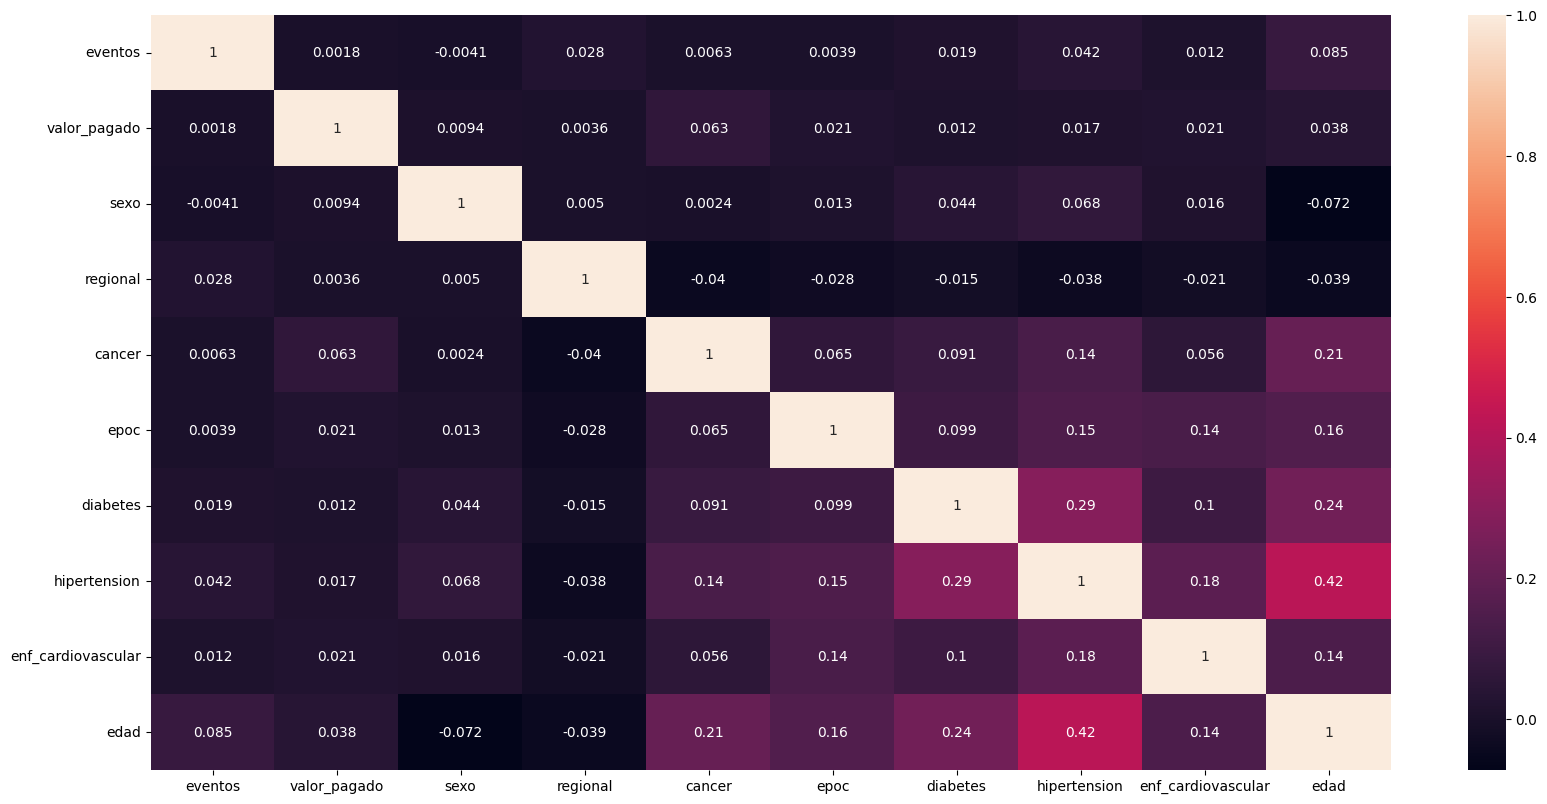

In [ ]:
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=100);
sns.heatmap(union_all_pd.corr(), annot = True);

In [ ]:
#Matriz de correlaciones de la base de datos grande 
cor = union_exp_prueba.corr()
cor_target = abs(cor["valor_pagado"])
relevant_features = cor_target[cor_target>0] ## DEFINIR ESTA VARIABLE
relevant_features_columns = list(relevant_features.index)

cor_relevante_features = union_exp_prueba[relevant_features_columns].corr()
union_all_factorized_features = union_exp_prueba[relevant_features_columns]
relevant_features

eventos               0.001766
valor_pagado          1.000000
sexo                  0.009431
regional              0.003591
cancer                0.063381
epoc                  0.020864
diabetes              0.012031
hipertension          0.017263
enf_cardiovascular    0.020567
edad                  0.038431
Name: valor_pagado, dtype: float64

In [ ]:
# El vector Target será valor_pago. Este dependerá del tipo de reclamación, cabe destacar que existen 39 tipos de reclamos, por ende,
# se crearan dataframes que  agrupen ciertas categorias. Esta agrupación se dará teniedo encuenta la cantidad de veces que se han registrado 
# las determinadas reclamaciones.
#DF1: CONSULTA EXTERNA - EXAMENES DE DIAGNOSTICO - LABORATORIO CLINICO - CONSULTA DE URGENCIAS
#DF2: CIRUGIA AMBULATORIA POR ENFERMEDAD - TRATAMIENTOS ESPECIFICOS - TRATAMIENTO MEDICO AMBULATORIO POR ACCIDENTES - CONSULTAS PRENATALES 
#DF3: ANEXO EXEQUIAL - TRATAMIENTO QUIRURGICO HOSPITALARIO POR ENFERMEDAD CONGENITA - ANEXO EXEQUIAL
union_exp_prueba['reclamacion'].value_counts()

CONSULTA EXTERNA                                                   398070
EXAMENES DE DIAGNOSTICO                                            220175
LABORATORIO CLINICO                                                165185
CONSULTA DE URGENCIAS                                              116185
CIRUGIA AMBULATORIA POR ENFERMEDAD                                  33498
FISIOTERAPIA ILIMITADA                                              31101
TRATAMIENTOS ESPECIFICOS                                            15695
TRATAMIENTO MEDICO AMBULATORIO POR ACCIDENTES                       12451
CONSULTAS PRENATALES                                                10714
TRATAMIENTO MEDICO HOSPITALARIO POR ENFERMEDAD                       8969
TRATAMIENTO QUIRURGICO HOSPITALARIO POR ENFERMEDAD                   6457
CIRUGIA AMBULATORIA POR ACCIDENTE                                    5535
TRATAMIENTO AMBULATORIO POR CANCER                                   4749
PAMD                                  